# Credits
> This code is a slight modification to a translation (TensorFlow --> PyTorch) of a previous version of the [02456](http://kurser.dtu.dk/course/02456) course material. 
> [Original repo link (TensorFlow)](https://github.com/DeepLearningDTU/02456-deep-learning).
> [Translated repo link (PyTorch)](https://github.com/munkai/pytorch-tutorial/tree/master/2_intermediate).

In [1]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

# MNIST dataset
MNIST is a dataset that is often used for benchmarking. The MNIST dataset consists of 70,000 images of handwritten digits from 0-9. The dataset is split into a 50,000 images training set, 10,000 images validation set and 10,000 images test set. The images are 28x28 pixels, where each pixel represents a normalised value between 0-255 (0=black and 255=white).

![MNIST.Exampel](../static_files/mnist.png)


## Primer
We use a feedforward neural network to classify the 28x28 mnist images. `num_features` is therefore $28 * 28=784$, i.e. we represent each image as a vector. The ordering of the pixels in the vector does not matter, so we could permutate all images using the same permutation and still get the same performance. (You are of course encouraged to try this using ``numpy.random.permutation`` to get a random permutation. This task is therefore called the _permutation invariant_ MNIST. Obviously this throws away a lot of structure in the data. In the next module we'll fix this with the convolutional neural network wich encodes prior knowledgde about data that has either spatial or temporal structure.  

## MNIST
First let's load the MNIST dataset and plot a few examples:

In [2]:
!if [ ! -f mnist.npz ]; then wget -N https://github.com/maximai/placeholder_repo/raw/master/mnist.npz; else echo "mnist.npz already downloaded"; fi

! was unexpected at this time.


In [2]:
#To speed up training we'll only work on a subset of the data
data = np.load('mnist.npz')
num_classes = 10
n_train = 1000
n_val = 500

x_train = data['X_train'][:n_train].astype('float32')
targets_train = data['y_train'][:n_train].astype('int32')

x_valid = data['X_valid'][:n_val].astype('float32')
targets_valid = data['y_valid'][:n_val].astype('int32')

x_test = data['X_test'][:n_val].astype('float32')
targets_test = data['y_test'][:n_val].astype('int32')

print("Information on dataset")
print("x_train", x_train.shape)
print("targets_train", targets_train.shape)
print("x_valid", x_valid.shape)
print("targets_valid", targets_valid.shape)
print("x_test", x_test.shape)
print("targets_test", targets_test.shape)

Information on dataset
x_train (1000, 784)
targets_train (1000,)
x_valid (500, 784)
targets_valid (500,)
x_test (500, 784)
targets_test (500,)


In [3]:
data

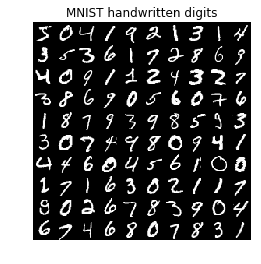

In [4]:
#plot a few MNIST examples
idx, dim, classes = 0, 28, 10
# create empty canvas
canvas = np.zeros((dim*classes, classes*dim))

# fill with tensors
for i in range(classes):
    for j in range(classes):
        canvas[i*dim:(i+1)*dim, j*dim:(j+1)*dim] = x_train[idx].reshape((dim, dim))
        idx += 1

# visualize matrix of tensors as gray scale image
plt.figure(figsize=(4, 4))
plt.axis('off')
plt.imshow(canvas, cmap='gray')
plt.title('MNIST handwritten digits')
plt.show()

## Model

One of the large challenges in deep learning is the amount of hyperparameters that needs to be selected, and the lack of a good principled way of selecting them.
Hyperparameters can be found by experience (guessing) or some search procedure (often quite slow).
Random search is easy to implement and performs decent: http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf . 
More advanced search procedures include [Spearmint](https://github.com/JasperSnoek/spearmint) and many others.

**In practice a lot of trial and error is almost always involved.** This can be frustrating and time consuming, but the best thing to do is to think as a scientist, and go about it in a ordered manner --> monitor as much as you can, take notes, and be deliberate!

Below are some guidelines that you can use as a starting point to some of the most important hyperparameters. 
(*regularization* is also very important, but will be covered later.)


### Ballpark estimates of hyperparameters
__Number of hidden units and network structure:__
You'll have to experiment. One rarely goes below 512 units for feedforward networks (unless your are training on CPU...).
There's some research into stochastic depth networks: https://arxiv.org/pdf/1603.09382v2.pdf, but in general this is trial and error.

__Parameter initialization:__
Parameter initialization is extremely important.
PyTorch has a lot of different initializers, check the [PyTorch API](http://pytorch.org/docs/master/nn.html#torch-nn-init). Often used initializer are
1. Kaming He
2. Xavier Glorot
3. Uniform or Normal with small scale (0.1 - 0.01)
4. Orthogonal (this usually works very well for RNNs)

Bias is nearly always initialized to zero using the [torch.nn.init.constant(tensor, val)](http://pytorch.org/docs/master/nn.html#torch.nn.init.constant)

__Mini-batch size:__
Usually people use 16-256. Bigger is not allways better. With smaller mini-batch size you get more updates and your model might converge faster. Also small batch sizes use less memory, which means you can train a model with more parameters.

__Nonlinearity:__ [The most commonly used nonliearities are](http://pytorch.org/docs/master/nn.html#non-linear-activations)
1. ReLU
2. Leaky ReLU
3. Elu
3. Sigmoid squash the output [0, 1], and are used if your output is binary (not used in the hidden layers)
4. Tanh is similar to sigmoid, but squashes in [-1, 1]. It is rarely used any more.
4. Softmax normalizes the the output to 1, and is used as output if you have a classification problem

See the plot below.

__Optimizer and learning rate:__
1. SGD + Momentum: learning rate 1.0 - 0.1 
2. ADAM: learning rate 3*1e-4 - 1e-5
3. RMSPROP: somewhere between SGD and ADAM


softmax should sum to one (approxiamtely): 1.0


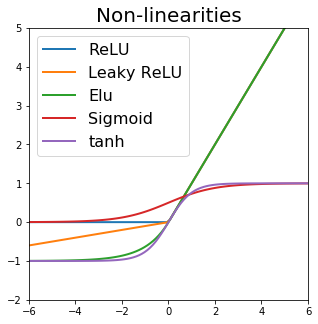

In [5]:
# Illustrate different output units
x = np.linspace(-6, 6, 100)
units = {
    "ReLU": lambda x: np.maximum(0, x),
    "Leaky ReLU": lambda x: np.maximum(0, x) + 0.1 * np.minimum(0, x),
    "Elu": lambda x: (x > 0) * x + (1 - (x > 0)) * (np.exp(x) - 1),
    "Sigmoid": lambda x: (1 + np.exp(-x))**(-1),
    "tanh": lambda x: (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
}

plt.figure(figsize=(5, 5))
[plt.plot(x, unit(x), label=unit_name, lw=2) for unit_name, unit in units.items()]
plt.legend(loc=2, fontsize=16)
plt.title('Non-linearities', fontsize=20)
plt.ylim([-2, 5])
plt.xlim([-6, 6])

# assert that all class probablities sum to one
softmax = lambda x: np.exp(x) / np.sum(np.exp(x))
print("softmax should sum to one (approxiamtely):", np.sum(softmax(x)))

In [559]:
#Hyperparameters
num_classes = 10
num_l1 = [144,144] # Hidden units - we use 2 layers
num_features = x_train.shape[1]
use_gpu = False    # Whether to allow GPU processing

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden, num_output, activation=None, p_dropout_int=0, p_dropout_final=0, use_bn=False):
        super(Net, self).__init__()
        
        # Make sure num_hidden is iterable
        if not hasattr(num_hidden, '__iter__'):
            num_hidden = [num_hidden]
        
        # Initialize ParameterLists to hold weights and biases
        # These will automatically register the added Parameters with the net,
        # so they are updated during training
        self.Weights = nn.ParameterList()
        if not use_bn:
            self.Biases = nn.ParameterList()
        else:
            # If we use batch normalization we do not need a bias.
            # Since we apply BN right after the linear trasnfor and BN learns it own bias,
            # this bias is redundant.
            self.Biases = []
        
        # Compute input- and output sizes for each layer
        num_in = [num_features]
        num_in.extend(num_hidden)
        num_out = list(num_hidden)
        num_out.append(num_output)
        
        # Init all weights and biases
        for nin, nout in zip(num_in, num_out):
            # Init weights using Kaiming He with normal distribution
            self.Weights.append(Parameter(init.kaiming_normal_(torch.Tensor(nout,nin))))
            # Init biases with 0
            if not use_bn:
                self.Biases.append(Parameter(init.constant_(torch.Tensor(nout), 0)))
            else:
                # See comment on line 24
                self.Biases.append(torch.zeros(nout))
            
        # Define activation function
        if activation is None:
            activation = torch.nn.ReLU() # Use ReLU as default
        self.activation = activation
        
        # Store dropout functions
        self.dropout_int = nn.Dropout2d(p_dropout_int)
        self.dropout_final = nn.Dropout2d(p_dropout_final)
        
        # Register batch normalization for each layer
        self.use_bn = use_bn
        if use_bn:
            self.BNs = nn.ModuleList()
            for n in num_out:
                self.BNs.append(nn.BatchNorm1d(n))
            

    def forward(self, x):
        # Loop over all hidden layers
        for i, (W, b) in enumerate(zip(self.Weights[:-1], self.Biases[:-1])):
            x = self.dropout_int(x) # Add internal dropout to input
            x = F.linear(x, W, b)   # Do linear mapping
            if self.use_bn:
                x = self.BNs[i](x)  # Add batch normalization if needed
                    
            x = self.activation(x)  # Do non-linear activation
        
        # Last layer
        x = self.dropout_final(x)                              # Add final dropout
        x = F.linear(x, self.Weights[-1], self.Biases[-1])     # Add final linear mapping
        if self.use_bn:
            x = self.BNs[-1](x)                                # Add final batch normalization
        return F.softmax(x, dim=1)                             # Apply softmax to produce outputs
    

# Set device to run training on
if use_gpu and torch.cuda.device_count() > 0:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('Device is:', device)

# Init net
# NOTE: In the paper on batch normalization it is recommended not to use dropout with batch normalization.
# However, I found that it gave better results.
net = Net(num_features,    # Number of features
          num_l1,          # Number of hidden units
          num_classes,     # Number of output classes
          torch.nn.ReLU(), # Activation function
          0.10,            # Dropout probability for internal nodes
          0.05,            # Dropout probability for final nodes
          True)            # Use batch normalization
net = net.to(device) # Move net to device

Device is: cpu


In [560]:
# Setup the optimizer
optimizer = optim.Adam(net.parameters(), lr=2.5e-3, weight_decay=5e-5)

# Setup adaptive learning rate
# This should help the network improve in the later stages of training where it is
# (hopefully!) closer to a minimum.
n_half = 100
lam = 0.5 ** (1.0 / n_half) # Exponential decay which halves the learning rate every n_half iterations
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: lam ** epoch)

# Setup loss function
criterion = nn.CrossEntropyLoss()

In [561]:
#Test the forward pass with dummy data
x = np.random.normal(0, 1, (45, dim*dim)).astype('float32')

print(net(Variable(torch.from_numpy(x)).to(device)).size())

torch.Size([45, 10])


# Build the training loop

We train the network by calculating the gradient w.r.t the cost function and update the parameters in direction of the negative gradient. 


When training neural network you always use mini batches. Instead of calculating the average gradient using the entire dataset you approximate the gradient using a mini-batch of typically 16 to 256 samples. The paramters are updated after each mini batch. Networks converge much faster using mini batches because the parameters are updated more often.

We build a loop that iterates over the training data. Remember that the parameters are updated each time ``optimizer.step()`` is called.

Epoch  1 : Train Loss 0.026839 , Train acc 0.415365, Valid acc 0.363281
Epoch 21 : Train Loss 0.023500 , Train acc 0.955729, Valid acc 0.855469
Epoch 41 : Train Loss 0.022266 , Train acc 0.989583, Valid acc 0.882812
Epoch 61 : Train Loss 0.021252 , Train acc 0.998698, Valid acc 0.886719
Epoch 81 : Train Loss 0.020486 , Train acc 1.000000, Valid acc 0.890625
Epoch 101 : Train Loss 0.019926 , Train acc 1.000000, Valid acc 0.890625
Epoch 121 : Train Loss 0.019527 , Train acc 1.000000, Valid acc 0.898438
Epoch 141 : Train Loss 0.019218 , Train acc 1.000000, Valid acc 0.894531
Epoch 161 : Train Loss 0.019016 , Train acc 1.000000, Valid acc 0.902344
Epoch 181 : Train Loss 0.018837 , Train acc 1.000000, Valid acc 0.902344
Epoch 201 : Train Loss 0.018703 , Train acc 1.000000, Valid acc 0.898438
Epoch 221 : Train Loss 0.018608 , Train acc 1.000000, Valid acc 0.898438
Epoch 241 : Train Loss 0.018522 , Train acc 1.000000, Valid acc 0.902344
Epoch 261 : Train Loss 0.018454 , Train acc 1.000000, Va

(Text(0.5,0,'Updates'), Text(0,0.5,'Acc'))

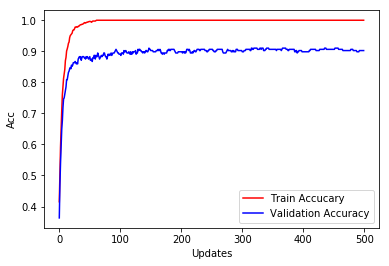

In [562]:
# we could have done this ourselves,
# but we should be aware of sklearn and it's tools
from sklearn.metrics import accuracy_score

# setting hyperparameters and gettings epoch sizes
l1_weight_decay = 0.001 # Penalty for L1 norm
batch_size = 256
num_epochs = 500
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

l1loss = nn.L1Loss(reduction='sum')

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    scheduler.step() # Update learning rate
    net.train()
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_train[slce])).to(device)
        output = net(x_batch)
        
        # compute gradients given loss
        target_batch = Variable(torch.from_numpy(targets_train[slce]).long()).to(device)
        batch_loss = criterion(output, target_batch)
        # Apply L1 loss
        batch_loss += (l1_weight_decay / batch_size) * sum(l1loss(W, torch.zeros_like(W, requires_grad=False)) for W in net.Weights) 
        
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_train[slce])).to(device)
        
        output = net(x_batch)
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce])
        train_preds += list(preds.data.cpu().numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_valid[slce])).to(device)
        
        output = net(x_batch)
        preds = torch.max(output, 1)[1]
        val_preds += list(preds.data.cpu().numpy())
        val_targs += list(targets_valid[slce])

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 20 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

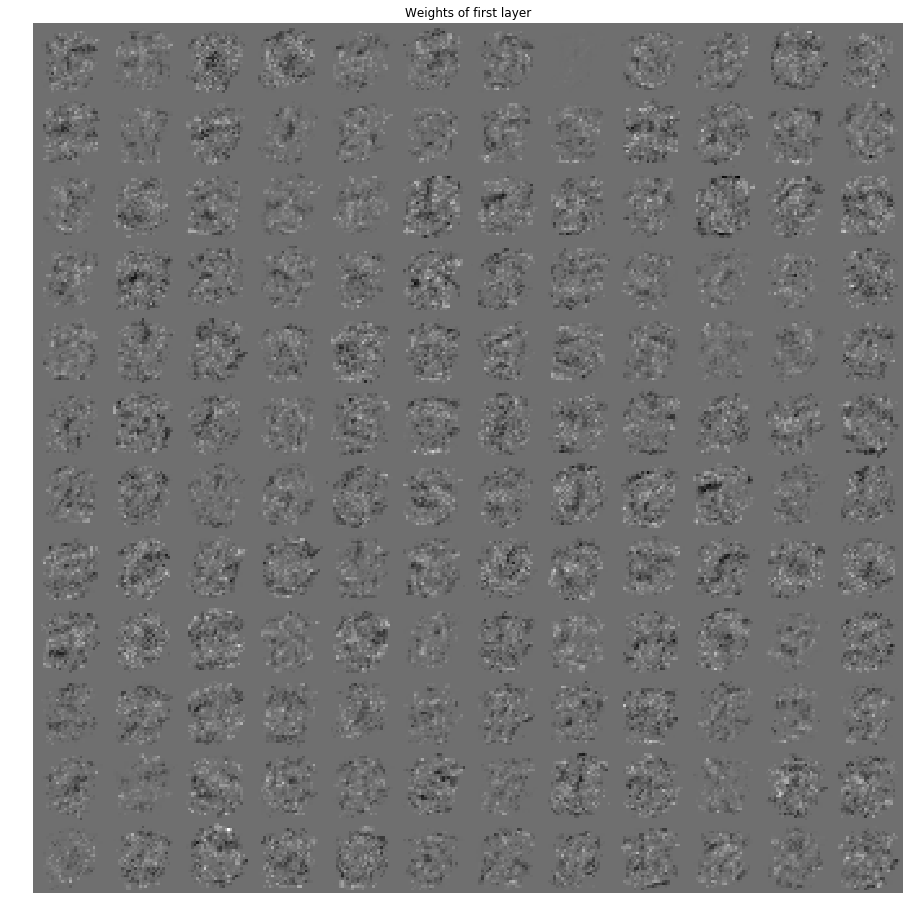

In [563]:
# Plot first set of weights
idx, dim, n = 0, 28, int(np.floor(np.sqrt(net.Weights[0].size()[0])))
# create empty canvas
canvas = np.zeros((dim*n, n*dim))

# Fill canvas
for i in range(n):
    for j in range(n):
        canvas[i*dim:(i+1)*dim, j*dim:(j+1)*dim] = net.Weights[0].cpu().data[idx,:].reshape((dim, dim))
        idx += 1

# Visualize matrix of tensors as gray scale image
plt.figure(figsize=(16, 16))
plt.axis('off')
plt.imshow(canvas, cmap='gray')
plt.title('Weights of first layer')
plt.show()

In the above we see that regularization promotes sparsity in the weights. It also appears like the network has learned to "focus" on the center part of the images, which is good since that is where the numbers are.

# Assignments

Try and add these modifications (might require some Googleing -- an important skill in deep learning):
- Kaiming He initialization instead of Xavier Glorot
- add an extra layer
- use the relu activation function
- add momentum to the optimizer
- use the ADAM optimizer instead of stochastic gradient descent

### Advanced - Regularization

Regularization is VERY important in practice and is used practically every time.
Many important results are completely dependent on cleaver use of regularization, and it is something you need to become familiar with if you want to work with deep learning.

- add L1 or L2 weight regularization (aka. weight decay) 
- add dropout to the network (**note** the `net.train()` and `net.eval()` are already in the code)
- add batchnorm

__Pointers on regularization hyperparameter:__
1. L2 and [L1 regularization](http://pytorch.org/docs/master/nn.html#torch.nn.L1Loss) (weight decay of optimization functions) 
  - Normal ranges: 1e-4  -  1e-8
1. [Dropout](http://pytorch.org/docs/master/nn.html?highlight=dropout#torch.nn.Dropout). Dropout rate 0.1-0.5
  - Remember to pick the correct version according to the input dimensionality
  - **NOTE** call `net.train()` before training to activate random dropout, and call `net.eval()` to deactivate dropout while validating or running inference with model.
1. [Batchnorm](http://pytorch.org/docs/master/nn.html#torch.nn.BatchNorm1d): Batchnorm also acts as a regularizer - Often very useful (faster and better convergence)
  - Remember to pick the correct version according to the input dimensionality
  - **NOTE** call `net.train()` before training to activate, and call `net.eval()` to have a non-stochastic variant while validating or running inference with model.
    

# Exercise from chapter 3

In the single-neuron discussion at the start of this section, I argued that the cross-entropy is small if σ(z)≈y for all training inputs. The argument relied on y being equal to either 0 or 1. This is usually true in classification problems, but for other problems (e.g., regression problems) y can sometimes take values intermediate between 0 and 1. Show that the cross-entropy is still minimized when σ(z)=y for all training inputs. When this is the case the cross-entropy has the value:
$$
C = -\frac1n \sum_x [y \ln y + (1 - y)\ln(1 - y) ].
$$
The quantity $-[y \ln y + (1 - y)\ln(1 - y)] is sometimes known as the binary entropy.

<hline>

## Answer:

Let $x_{(i)}$, $y_{(i)}$, and $a_{(i)}$ denote the $i$th training sample, desired output, and neuron output, respectively. The cross entropy function $C$ is given as
$$
C = -\frac1n \sum_{i} \left[ y_{(i)} \ln a_{(i)} + (1 - y_{(i)})\ln(1 - a_{(i)}) \right].
$$
We now differentiate $C$ wrt. $a_{(i)}$, and get
$$
\frac{\partial C}{\partial a_{(i)}} = -\frac1n \left[ \frac{y_{(i)}}{a_{(i)}} - \frac{1 - y_{(i)}}{1 - a_{(i)}} \right].
$$
Clearly, if $a_{(i)} = y_{(i)}$, then both fractions in the above are 1, and the derivative is 0. Thus, $a_{(i)} = y_{(i)}$ is indeed a stationary point for $C$. We now verify that it is indeed a minimum, by looking at the hessian. The second derivatives are
$$
\frac{\partial^2 C}{\partial a_{(i)} \partial a_{(j)}} = 0 \quad \text{for} \quad i \neq j,
$$
and
$$
\frac{\partial^2 C}{\partial^2 a_{(i)}} = \frac1n \left[ \frac{y_{(i)}}{a_{(i)}^2} + \frac{1 - y_{(i)}}{(1 - a_{(i)})^2} \right].
$$
Assuming $a_{(i)} = y_{(i)}$ the above reduces to
$$
\frac{\partial^2 C}{\partial^2 a_{(i)}} = \frac1n \left[ \frac{1}{y_{(i)}} + \frac{1}{1 - y_{(i)}} \right],
$$
and since $y_{(i)} \in [0, 1]$ this must be a positive number. Thus, the hessian for $C$ is a diagonal matrix where each diagonal entry is positive, and therefore it must be a positive definite matrix. This verifies that $a_{(i)} = y_{(i)}$ indeed minimizes $C$.

You are done for now. [Good job.](https://media1.tenor.com/images/0fd559b07f2174f9b8b7dbde7c5a67ca/tenor.gif)